In [1]:
import numpy as np
import matplotlib.pyplot as plt

def solve_laplace_sor(Lx, Ly, Nx, Ny, T_hot, T_cold, omega, tol=1e-5, max_iter=20000):
    """
    使用 SOR 迭代法求解

    Lx: 板的x方向长度
    Ly: 板的y方向长度
    Nx: x方向的网格点数
    Ny: y方向的网格点数
    T_hot: 热边的温度
    T_cold: 其他三条边的温度
    omega: 松弛因子
    tol: 收敛容差
    max_iter: 最大迭代次数

    返回:
    x: x坐标
    y: y坐标
    T: 温度场
    iterations: 达到收敛所需的迭代次数
    """

    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y)
    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)

    T = np.full((Ny, Nx), T_cold) # 用冷边温度初始化整个板

    T[:, 0] = T_cold 
    T[:, -1] = T_cold 
    T[0, :] = T_cold 
    T[-1, :] = T_hot 

    # 预计算 SOR 公式的常数部分
    factor1 = omega / (2 * (1/dx**2 + 1/dy**2))
    factor_x = factor1 / dx**2
    factor_y = factor1 / dy**2
    factor_omega = 1 - omega

    # SOR 迭代
    iterations = 0
    error = tol + 1

    while error > tol and iterations < max_iter:
        T_old = T.copy()
        error = 0.0

        # 遍历内部节点
        for j in range(1, Ny - 1):
            for i in range(1, Nx - 1):
                # SOR 更新公式
                T_new_ij = factor_x * (T[j, i+1] + T[j, i-1]) + factor_y * (T[j+1, i] + T[j-1, i])
                T[j, i] = factor_omega * T_old[j, i] + T_new_ij
                # 最大绝对误差
                error = max(error, abs(T[j, i] - T_old[j, i]))

        iterations += 1

    # if iterations == max_iter:
    #     print(f"达到最大迭代次数")
    # else:
    #     print(f"收敛于 {iterations} 次迭代。误差: {error:.2e}")

    return x, y, T, iterations

def plot_temperature_field(x, y, T, Nx, Ny, omega):
    """绘制温度场等温线图"""
    plt.figure(figsize=(8, 6 * (y[-1]/x[-1]))) # 根据板的比例调整图形大小
    levels = np.linspace(np.min(T), np.max(T), 11) # 绘制 11 条等温线
    contour = plt.contour(x, y, T, levels=levels, colors='black', linestyles='dashed', linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')
    contour_filled = plt.contourf(x, y, T, levels=levels, cmap='jet')
    plt.colorbar(contour_filled, label='temperature (°C)')
    plt.title(f'temp field (Nx={Nx}, Ny={Ny}, $\\omega$={omega:.2f})')
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    plt.axis('equal') # 确保 x 和 y 轴比例一致
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

(1) 使用迭代法计算板内稳定的温度场，并绘出等温线；

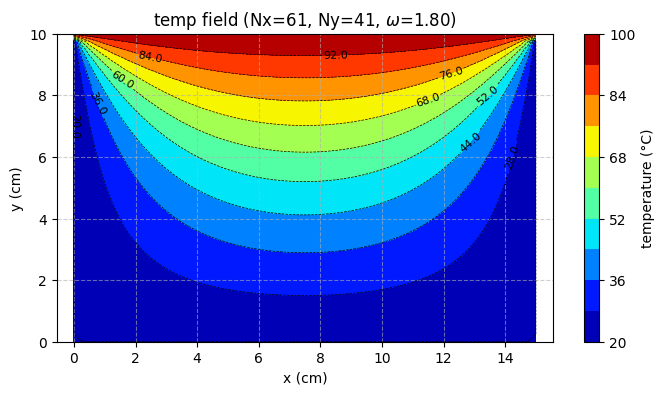

In [2]:
Lx = 15.0 
Ly = 10.0 
Nx = 61
Ny = 41
omega = 1.8 

T_hot = 100.0 
T_cold = 20.0
tolerance = 1e-5 

x, y, T, num_iterations = solve_laplace_sor(Lx, Ly, Nx, Ny, T_hot, T_cold, omega, tol=tolerance)

# 绘制结果
plot_temperature_field(x, y, T, Nx, Ny, omega)

(2) 采用不同的松弛因子，比较收敛速度；

In [3]:
omega_list = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.85, 1.9, 1.95]
for omega in omega_list:
    x, y, T, num_iterations = solve_laplace_sor(Lx, Ly, Nx, Ny, T_hot, T_cold, omega, tol=tolerance)
    print(f"omega={omega:.2f}, 收敛于 {num_iterations} 次迭代")

omega=0.40, 收敛于 7660 次迭代
omega=0.60, 收敛于 4754 次迭代
omega=0.80, 收敛于 3208 次迭代
omega=1.00, 收敛于 2232 次迭代
omega=1.20, 收敛于 1551 次迭代
omega=1.40, 收敛于 1041 次迭代
omega=1.60, 收敛于 636 次迭代
omega=1.80, 收敛于 291 次迭代
omega=1.85, 收敛于 202 次迭代
omega=1.90, 收敛于 165 次迭代
omega=1.95, 收敛于 333 次迭代


1. 整体收敛所需迭代次数随着omega的提高先降后升，最小值在omega=1.90处取得
2. 超松弛的收敛表现好于亚松弛和G-S迭代的表现

(3) 采用不同的网格尺度，观察最佳松弛因子的变化。

In [5]:
omega_list = [1.8, 1.85, 1.875, 1.9, 1.925, 1.95,1.975]
Nx_list = [31, 61, 91, 121, 151, 181]
Ny_list = [21, 41, 61, 81, 101, 121]
for Nx, Ny in zip(Nx_list, Ny_list):
    best_omega = None
    min_iterations = float('inf')
    for omega in omega_list:
        x, y, T, num_iterations = solve_laplace_sor(Lx, Ly, Nx, Ny, T_hot, T_cold, omega, tol=tolerance)
        if num_iterations < min_iterations:
            min_iterations = num_iterations
            best_omega = omega
    print(f"最佳松弛因子: {best_omega:.2f} (Nx={Nx}, Ny={Ny})")


最佳松弛因子: 1.80 (Nx=31, Ny=21)
最佳松弛因子: 1.88 (Nx=61, Ny=41)
最佳松弛因子: 1.93 (Nx=91, Ny=61)
最佳松弛因子: 1.95 (Nx=121, Ny=81)
最佳松弛因子: 1.95 (Nx=151, Ny=101)
最佳松弛因子: 1.95 (Nx=181, Ny=121)


可见当网格划分越细，最佳omega值就越大（越接近2）

AI声明：使用AI实现了绘制等温图，以及实验循环部分的代码补全。